In [1]:
import pandas as pd
import re
import lief
import hashlib
import numpy as np
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
#!/usr/bin/python
''' Extracts some basic features from PE files. Many of the features
implemented have been used in previously published works. For more information,
check out the following resources:
* Schultz, et al., 2001: http://128.59.14.66/sites/default/files/binaryeval-ieeesp01.pdf
* Kolter and Maloof, 2006: http://www.jmlr.org/papers/volume7/kolter06a/kolter06a.pdf
* Shafiq et al., 2009: https://www.researchgate.net/profile/Fauzan_Mirza/publication/242084613_A_Framework_for_Efficient_Mining_of_Structural_Information_to_Detect_Zero-Day_Malicious_Portable_Executables/links/0c96052e191668c3d5000000.pdf
* Raman, 2012: http://2012.infosecsouthwest.com/files/speaker_materials/ISSW2012_Selecting_Features_to_Classify_Malware.pdf
* Saxe and Berlin, 2015: https://arxiv.org/pdf/1508.03096.pdf

It may be useful to do feature selection to reduce this set of features to a meaningful set
for your modeling problem.
'''

class FeatureType(object):
    ''' Base class from which each feature type may inherit '''

    name = ''
    dim = 0

    def __repr__(self):
        return '{}({})'.format(self.name, self.dim)

    def raw_features(self, bytez, lief_binary):
        ''' Generate a JSON-able representation of the file '''
        raise (NotImplemented)

    def process_raw_features(self, raw_obj):
        ''' Generate a feature vector from the raw features '''
        raise (NotImplemented)

    def feature_vector(self, bytez, lief_binary):
        ''' Directly calculate the feature vector from the sample itself. This should only be implemented differently
        if there are significant speedups to be gained from combining the two functions. '''
        return self.process_raw_features(self.raw_features(bytez, lief_binary))


class ByteHistogram(FeatureType):
    ''' Byte histogram (count + non-normalized) over the entire binary file '''

    name = 'histogram'
    dim = 256

    def __init__(self):
        super(FeatureType, self).__init__()

    def raw_features(self, bytez, lief_binary):
        counts = np.bincount(np.frombuffer(bytez, dtype=np.uint8), minlength=256)
        return counts.tolist()

    def process_raw_features(self, raw_obj):
        counts = np.array(raw_obj, dtype=np.float32)
        sum = counts.sum()
        normalized = counts / sum
        return normalized


class ByteEntropyHistogram(FeatureType):
    ''' 2d byte/entropy histogram based loosely on (Saxe and Berlin, 2015).
    This roughly approximates the joint probability of byte value and local entropy.
    See Section 2.1.1 in https://arxiv.org/pdf/1508.03096.pdf for more info.
    '''

    name = 'byteentropy'
    dim = 256

    def __init__(self, step=1024, window=2048):
        super(FeatureType, self).__init__()
        self.window = window
        self.step = step

    def _entropy_bin_counts(self, block):
        # coarse histogram, 16 bytes per bin
        c = np.bincount(block >> 4, minlength=16)  # 16-bin histogram
        p = c.astype(np.float32) / self.window
        wh = np.where(c)[0]
        H = np.sum(-p[wh] * np.log2(
            p[wh])) * 2  # * x2 b.c. we reduced information by half: 256 bins (8 bits) to 16 bins (4 bits)

        Hbin = int(H * 2)  # up to 16 bins (max entropy is 8 bits)
        if Hbin == 16:  # handle entropy = 8.0 bits
            Hbin = 15

        return Hbin, c

    def raw_features(self, bytez, lief_binary):
        output = np.zeros((16, 16), dtype=np.int)
        a = np.frombuffer(bytez, dtype=np.uint8)
        if a.shape[0] < self.window:
            Hbin, c = self._entropy_bin_counts(a)
            output[Hbin, :] += c
        else:
            # strided trick from here: http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
            shape = a.shape[:-1] + (a.shape[-1] - self.window + 1, self.window)
            strides = a.strides + (a.strides[-1],)
            blocks = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::self.step, :]

            # from the blocks, compute histogram
            for block in blocks:
                Hbin, c = self._entropy_bin_counts(block)
                output[Hbin, :] += c

        return output.flatten().tolist()

    def process_raw_features(self, raw_obj):
        counts = np.array(raw_obj, dtype=np.float32)
        sum = counts.sum()
        normalized = counts / sum
        return normalized


class SectionInfo(FeatureType):
    ''' Information about section names, sizes and entropy.  Uses hashing trick
    to summarize all this section info into a feature vector.
    '''

    name = 'section'
    dim = 5 + 50 + 50 + 50 + 50 + 50

    def __init__(self):
        super(FeatureType, self).__init__()

    @staticmethod
    def _properties(s):
        return [str(c).split('.')[-1] for c in s.characteristics_lists]

    def raw_features(self, bytez, lief_binary):
        if lief_binary is None:
            return {"entry": "", "sections": []}

        # properties of entry point, or if invalid, the first executable section
        try:
            entry_section = lief_binary.section_from_offset(lief_binary.entrypoint).name
        except lief.not_found:
            # bad entry point, let's find the first executable section
            entry_section = ""
            for s in lief_binary.sections:
                if lief.PE.SECTION_CHARACTERISTICS.MEM_EXECUTE in s.characteristics_lists:
                    entry_section = s.name
                    break

        raw_obj = {"entry": entry_section}
        raw_obj["sections"] = [{
            'name': s.name,
            'size': s.size,
            'entropy': s.entropy,
            'vsize': s.virtual_size,
            'props': self._properties(s)
        } for s in lief_binary.sections]
        return raw_obj

    def process_raw_features(self, raw_obj):
        sections = raw_obj['sections']
        general = [
            len(sections),  # total number of sections
            # number of sections with nonzero size
            sum(1 for s in sections if s['size'] == 0),
            # number of sections with an empty name
            sum(1 for s in sections if s['name'] == ""),
            # number of RX
            sum(1 for s in sections if 'MEM_READ' in s['props'] and 'MEM_EXECUTE' in s['props']),
            # number of W
            sum(1 for s in sections if 'MEM_WRITE' in s['props'])
        ]
        # gross characteristics of each section
        section_sizes = [(s['name'], s['size']) for s in sections]
        section_sizes_hashed = FeatureHasher(50, input_type="pair").transform([section_sizes]).toarray()[0]
        section_entropy = [(s['name'], s['entropy']) for s in sections]
        section_entropy_hashed = FeatureHasher(50, input_type="pair").transform([section_entropy]).toarray()[0]
        section_vsize = [(s['name'], s['vsize']) for s in sections]
        section_vsize_hashed = FeatureHasher(50, input_type="pair").transform([section_vsize]).toarray()[0]
        entry_name_hashed = FeatureHasher(50, input_type="string").transform([raw_obj['entry']]).toarray()[0]
        characteristics = [p for s in sections for p in s['props']]
        characteristics_hashed = FeatureHasher(50, input_type="string").transform([characteristics]).toarray()[0]

        return np.hstack([
            general, section_sizes_hashed, section_entropy_hashed, section_vsize_hashed, entry_name_hashed,
            characteristics_hashed
        ]).astype(np.float32)


class ImportsInfo(FeatureType):
    ''' Information about imported libraries and functions from the
    import address table.  Note that the total number of imported
    functions is contained in GeneralFileInfo.
    '''

    name = 'imports'
    dim = 1280

    def __init__(self):
        super(FeatureType, self).__init__()

    def raw_features(self, bytez, lief_binary):
        imports = {}
        if lief_binary is None:
            return imports

        for lib in lief_binary.imports:
            if lib.name not in imports:
                imports[lib.name] = []  # libraries can be duplicated in listing, extend instead of overwrite

            # Clipping assumes there are diminishing returns on the discriminatory power of imported functions
            #  beyond the first 10000 characters, and this will help limit the dataset size
            imports[lib.name].extend([entry.name[:10000] for entry in lib.entries])

        return imports

    def process_raw_features(self, raw_obj):
        # unique libraries
        libraries = list(set([l.lower() for l in raw_obj.keys()]))
        libraries_hashed = FeatureHasher(256, input_type="string").transform([libraries]).toarray()[0]

        # A string like "kernel32.dll:CreateFileMappingA" for each imported function
        imports = [lib.lower() + ':' + e for lib, elist in raw_obj.items() for e in elist]
        imports_hashed = FeatureHasher(1024, input_type="string").transform([imports]).toarray()[0]

        # Two separate elements: libraries (alone) and fully-qualified names of imported functions
        return np.hstack([libraries_hashed, imports_hashed]).astype(np.float32)


class ExportsInfo(FeatureType):
    ''' Information about exported functions. Note that the total number of exported
    functions is contained in GeneralFileInfo.
    '''

    name = 'exports'
    dim = 128

    def __init__(self):
        super(FeatureType, self).__init__()

    def raw_features(self, bytez, lief_binary):
        if lief_binary is None:
            return []

        # Clipping assumes there are diminishing returns on the discriminatory power of exports beyond
        #  the first 10000 characters, and this will help limit the dataset size
        clipped_exports = [export[:10000] for export in lief_binary.exported_functions]

        return clipped_exports

    def process_raw_features(self, raw_obj):
        exports_hashed = FeatureHasher(128, input_type="string").transform([raw_obj]).toarray()[0]
        return exports_hashed.astype(np.float32)


class GeneralFileInfo(FeatureType):
    ''' General information about the file '''

    name = 'general'
    dim = 10

    def __init__(self):
        super(FeatureType, self).__init__()

    def raw_features(self, bytez, lief_binary):
        if lief_binary is None:
            return {
                'size': len(bytez),
                'vsize': 0,
                'has_debug': 0,
                'exports': 0,
                'imports': 0,
                'has_relocations': 0,
                'has_resources': 0,
                'has_signature': 0,
                'has_tls': 0,
                'symbols': 0
            }

        return {
            'size': len(bytez),
            'vsize': lief_binary.virtual_size,
            'has_debug': int(lief_binary.has_debug),
            'exports': len(lief_binary.exported_functions),
            'imports': len(lief_binary.imported_functions),
            'has_relocations': int(lief_binary.has_relocations),
            'has_resources': int(lief_binary.has_resources),
            'has_signature': int(lief_binary.has_signature),
            'has_tls': int(lief_binary.has_tls),
            'symbols': len(lief_binary.symbols),
        }

    def process_raw_features(self, raw_obj):
        return np.asarray(
            [
                raw_obj['size'], raw_obj['vsize'], raw_obj['has_debug'], raw_obj['exports'], raw_obj['imports'],
                raw_obj['has_relocations'], raw_obj['has_resources'], raw_obj['has_signature'], raw_obj['has_tls'],
                raw_obj['symbols']
            ],
            dtype=np.float32)


class HeaderFileInfo(FeatureType):
    ''' Machine, architecure, OS, linker and other information extracted from header '''

    name = 'header'
    dim = 62

    def __init__(self):
        super(FeatureType, self).__init__()

    def raw_features(self, bytez, lief_binary):
        raw_obj = {}
        raw_obj['coff'] = {'timestamp': 0, 'machine': "", 'characteristics': []}
        raw_obj['optional'] = {
            'subsystem': "",
            'dll_characteristics': [],
            'magic': "",
            'major_image_version': 0,
            'minor_image_version': 0,
            'major_linker_version': 0,
            'minor_linker_version': 0,
            'major_operating_system_version': 0,
            'minor_operating_system_version': 0,
            'major_subsystem_version': 0,
            'minor_subsystem_version': 0,
            'sizeof_code': 0,
            'sizeof_headers': 0,
            'sizeof_heap_commit': 0
        }
        if lief_binary is None:
            return raw_obj

        raw_obj['coff']['timestamp'] = lief_binary.header.time_date_stamps
        raw_obj['coff']['machine'] = str(lief_binary.header.machine).split('.')[-1]
        raw_obj['coff']['characteristics'] = [str(c).split('.')[-1] for c in lief_binary.header.characteristics_list]
        raw_obj['optional']['subsystem'] = str(lief_binary.optional_header.subsystem).split('.')[-1]
        raw_obj['optional']['dll_characteristics'] = [
            str(c).split('.')[-1] for c in lief_binary.optional_header.dll_characteristics_lists
        ]
        raw_obj['optional']['magic'] = str(lief_binary.optional_header.magic).split('.')[-1]
        raw_obj['optional']['major_image_version'] = lief_binary.optional_header.major_image_version
        raw_obj['optional']['minor_image_version'] = lief_binary.optional_header.minor_image_version
        raw_obj['optional']['major_linker_version'] = lief_binary.optional_header.major_linker_version
        raw_obj['optional']['minor_linker_version'] = lief_binary.optional_header.minor_linker_version
        raw_obj['optional'][
            'major_operating_system_version'] = lief_binary.optional_header.major_operating_system_version
        raw_obj['optional'][
            'minor_operating_system_version'] = lief_binary.optional_header.minor_operating_system_version
        raw_obj['optional']['major_subsystem_version'] = lief_binary.optional_header.major_subsystem_version
        raw_obj['optional']['minor_subsystem_version'] = lief_binary.optional_header.minor_subsystem_version
        raw_obj['optional']['sizeof_code'] = lief_binary.optional_header.sizeof_code
        raw_obj['optional']['sizeof_headers'] = lief_binary.optional_header.sizeof_headers
        raw_obj['optional']['sizeof_heap_commit'] = lief_binary.optional_header.sizeof_heap_commit
        return raw_obj

    def process_raw_features(self, raw_obj):
        return np.hstack([
            raw_obj['coff']['timestamp'],
            FeatureHasher(10, input_type="string").transform([[raw_obj['coff']['machine']]]).toarray()[0],
            FeatureHasher(10, input_type="string").transform([raw_obj['coff']['characteristics']]).toarray()[0],
            FeatureHasher(10, input_type="string").transform([[raw_obj['optional']['subsystem']]]).toarray()[0],
            FeatureHasher(10, input_type="string").transform([raw_obj['optional']['dll_characteristics']]).toarray()[0],
            FeatureHasher(10, input_type="string").transform([[raw_obj['optional']['magic']]]).toarray()[0],
            raw_obj['optional']['major_image_version'],
            raw_obj['optional']['minor_image_version'],
            raw_obj['optional']['major_linker_version'],
            raw_obj['optional']['minor_linker_version'],
            raw_obj['optional']['major_operating_system_version'],
            raw_obj['optional']['minor_operating_system_version'],
            raw_obj['optional']['major_subsystem_version'],
            raw_obj['optional']['minor_subsystem_version'],
            raw_obj['optional']['sizeof_code'],
            raw_obj['optional']['sizeof_headers'],
            raw_obj['optional']['sizeof_heap_commit'],
        ]).astype(np.float32)


class StringExtractor(FeatureType):
    ''' Extracts strings from raw byte stream '''

    name = 'strings'
    dim = 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1

    def __init__(self):
        super(FeatureType, self).__init__()
        # all consecutive runs of 0x20 - 0x7f that are 5+ characters
        self._allstrings = re.compile(b'[\x20-\x7f]{5,}')
        # occurances of the string 'C:\'.  Not actually extracting the path
        self._paths = re.compile(b'c:\\\\', re.IGNORECASE)
        # occurances of http:// or https://.  Not actually extracting the URLs
        self._urls = re.compile(b'https?://', re.IGNORECASE)
        # occurances of the string prefix HKEY_.  No actually extracting registry names
        self._registry = re.compile(b'HKEY_')
        # crude evidence of an MZ header (dropper?) somewhere in the byte stream
        self._mz = re.compile(b'MZ')

    def raw_features(self, bytez, lief_binary):
        allstrings = self._allstrings.findall(bytez)
        if allstrings:
            # statistics about strings:
            string_lengths = [len(s) for s in allstrings]
            avlength = sum(string_lengths) / len(string_lengths)
            # map printable characters 0x20 - 0x7f to an int array consisting of 0-95, inclusive
            as_shifted_string = [b - ord(b'\x20') for b in b''.join(allstrings)]
            c = np.bincount(as_shifted_string, minlength=96)  # histogram count
            # distribution of characters in printable strings
            csum = c.sum()
            p = c.astype(np.float32) / csum
            wh = np.where(c)[0]
            H = np.sum(-p[wh] * np.log2(p[wh]))  # entropy
        else:
            avlength = 0
            c = np.zeros((96,), dtype=np.float32)
            H = 0
            csum = 0

        return {
            'numstrings': len(allstrings),
            'avlength': avlength,
            'printabledist': c.tolist(),  # store non-normalized histogram
            'printables': int(csum),
            'entropy': float(H),
            'paths': len(self._paths.findall(bytez)),
            'urls': len(self._urls.findall(bytez)),
            'registry': len(self._registry.findall(bytez)),
            'MZ': len(self._mz.findall(bytez))
        }

    def process_raw_features(self, raw_obj):
        hist_divisor = float(raw_obj['printables']) if raw_obj['printables'] > 0 else 1.0
        return np.hstack([
            raw_obj['numstrings'], raw_obj['avlength'], raw_obj['printables'],
            np.asarray(raw_obj['printabledist']) / hist_divisor, raw_obj['entropy'], raw_obj['paths'], raw_obj['urls'],
            raw_obj['registry'], raw_obj['MZ']
        ]).astype(np.float32)


class PEFeatureExtractor(object):
    ''' Extract useful features from a PE file, and return as a vector of fixed size. '''

    features = [
        ByteHistogram(), 
        ByteEntropyHistogram(), 
        StringExtractor(), 
        GeneralFileInfo(), 
        HeaderFileInfo(), 
        SectionInfo(),
        ImportsInfo(), 
        ExportsInfo()
    ]
    dim = sum([fe.dim for fe in features])

    def raw_features(self, bytez):
        try:
            lief_binary = lief.PE.parse(list(bytez))
        except (lief.bad_format, lief.bad_file, lief.pe_error, lief.parser_error, RuntimeError) as e:
            print("lief error: ", str(e))
            lief_binary = None
        except Exception:  # everything else (KeyboardInterrupt, SystemExit, ValueError):
            raise

        features = {"sha256": hashlib.sha256(bytez).hexdigest()}
        features.update({fe.name: fe.raw_features(bytez, lief_binary) for fe in self.features})
        return features

    def process_raw_features(self, raw_obj):
        feature_vectors = [fe.process_raw_features(raw_obj[fe.name]) for fe in self.features]
        return np.hstack(feature_vectors).astype(np.float32)

    def feature_vector(self, bytez):
        return self.process_raw_features(self.raw_features(bytez))


In [4]:
def get_ember_feature(data):
    """
    int to bytes array
    :param data:
    :return:
    """
    bytes_data = bytes(map(int, data.split(",")))
    extractor = PEFeatureExtractor()
    features = np.array(extractor.feature_vector(bytes_data), dtype=np.float32)
    return features

In [19]:
train_x = pd.read_csv("./input/1_train.csv", header=None, sep="|", names=['row_data'], error_bad_lines=False)
tmp_v = train_x["row_data"].apply(lambda x: get_ember_feature(x))
train_x = pd.DataFrame(tmp_v.tolist(), dtype=float)
train_y = pd.read_csv("./input/1_train_label.csv", header=None, error_bad_lines=False)
del tmp_v
print('Shape of the train_x data: ', train_x.shape)
print('Shape of the train_y data: ', train_y.shape)

KeyboardInterrupt: 

In [10]:
bytes_data = bytes(map(int, bytes_ori["row_data"].loc[233].split(",")))
lief_binary = lief.PE.parse(list(bytes_data))
raw_obj = SectionInfo().raw_features(bytes_data, lief_binary)
print(raw_obj["sections"])

[{'name': '.text', 'size': 147456, 'entropy': -0.0, 'vsize': 143500, 'props': ['CNT_CODE', 'MEM_EXECUTE', 'MEM_READ']}, {'name': '.data', 'size': 4096, 'entropy': -0.0, 'vsize': 4240, 'props': ['CNT_INITIALIZED_DATA', 'MEM_READ', 'MEM_WRITE']}, {'name': '.rsrc', 'size': 12288, 'entropy': -0.0, 'vsize': 8252, 'props': ['CNT_INITIALIZED_DATA', 'MEM_READ']}]


In [11]:
def get_model(data, label):
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.05, random_state=5242)
    params = {'application': 'binary'}
    lgbm_dataset = lgb.Dataset(x_train, y_train.values.ravel())
    valid_sets = lgb.Dataset(x_test, y_test.values.ravel())

    model = lgb.train(params, lgbm_dataset, 100000, valid_sets=valid_sets, early_stopping_rounds=10, 
                     verbose_eval=False)
    return model

In [17]:
test_x = pd.read_csv("./input/test.csv", header=None, sep="|", names=['row_data'], error_bad_lines=False)
tmp_v = test_x["row_data"].apply(lambda x: get_ember_feature(x))
test_x = pd.DataFrame(tmp_v.tolist(), dtype=float)
test_y = pd.read_csv("./input/test_label.csv", header=None, error_bad_lines=False)
del tmp_v
print('Shape of the test_x data: ', test_x.shape)
print('Shape of the test_y data: ', test_y.shape)

Shape of the test_x data:  (143180, 2351)
Shape of the test_y data:  (143180, 1)


In [13]:
def estimate_model(model, test_x, test_y):
    from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix

    y_p = model.predict(test_x)
    y_pred = np.zeros((len(y_p), 1))
    for i in range(len(y_p)):
        y_pred[i, 0] = y_p[i]

    loss = log_loss(test_y, y_pred)
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y, (y_pred > 0.5).astype(int))
    print("loss : %.5f" % loss)
    print("auc score : %.5f" % auc)
    print("accuracy score : %.5f" % acc)

    fp_np_index = np.where(test_y == 0)
    fp_np = y_pred[fp_np_index].shape[0]
    thre_index = int(np.ceil(fp_np - fp_np * 0.001))

    sorted_pred_prob = np.sort(y_pred[fp_np_index], axis=0)
    thre = sorted_pred_prob[thre_index]
    if thre == 1:
        thre = max(sorted_pred_prob[np.where(sorted_pred_prob != 1)])

    y_pred_prob = np.vstack((y_pred.transpose(), (1 - y_pred).transpose())).transpose()
    y_pred_prob[:, 1] = thre
    y_pred_label = np.argmin(y_pred_prob, axis=-1)

    tn, fp, fn, tp = confusion_matrix(test_y, y_pred_label).ravel()
    fp_rate = fp / (fp + tn)
    recall_rate = tp / (tp + fn)

    print("thre: %.5f"%  thre)
    print("fp:  %.5f"%  fp_rate)
    print("recall:  %.5f"%  recall_rate)
    
    return auc, loss, recall_rate

Plot feature importances...


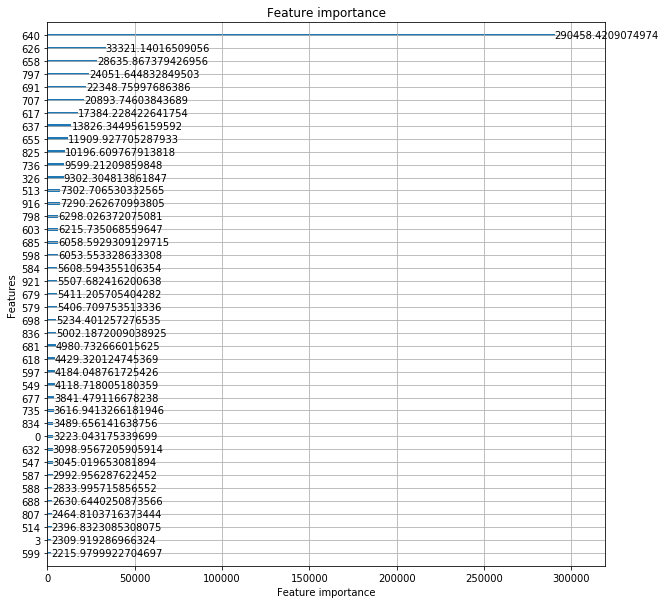

In [18]:
import matplotlib.pyplot as plt
model = get_model(train_x, train_y)
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=41, figsize=(10, 10), importance_type='gain')
plt.show()

In [3]:
bytes_ori = pd.read_csv("./input/1_train.csv", header=None, sep="|", names=['row_data'], error_bad_lines=False)

In [47]:
by_name = {}
size = bytes_ori["row_data"].shape[0]
for idx in range(size):
    bytes_data = bytes(map(int, bytes_ori["row_data"].loc[idx].split(",")))
    try:
        lief_binary = lief.PE.parse(list(bytes_data))
    except (lief.bad_format, lief.bad_file, lief.pe_error, lief.parser_error, RuntimeError) as e:
        print(idx)
        continue
    for idy, item in enumerate(lief_binary.sections):
        if by_name.get(item.name) is None:
            by_name[item.name] = 1
        else:
            by_name[item.name] = by_name[item.name] + 1
by_name

71148


{'.text': 93300,
 '.data': 82115,
 '.rsrc': 91636,
 '.rdata': 57927,
 '.bss': 9528,
 '.idata': 16738,
 '.code': 1575,
 '.reloc': 50172,
 '.MPRESS1': 100,
 '.MPRESS2': 100,
 '.ndata': 2240,
 '.pdata': 6408,
 'UPX0': 9445,
 'UPX1': 9443,
 '.brdata': 2454,
 '.tc': 166,
 '.xdata': 3151,
 '.CRT': 6608,
 '.nkh\x07': 4421,
 '.vsp\x06': 2,
 'rdata': 2654,
 'gfelmge': 1733,
 'lkcaqyc': 1572,
 '.sdata': 739,
 'UPX2': 5811,
 '.gfids': 2630,
 'CODE': 3132,
 'DATA': 3158,
 'BSS': 3018,
 '.tls': 9136,
 '.eh_fram': 840,
 '.itext': 1125,
 '.didat': 1244,
 '.rdata3': 63,
 '.rdata2': 73,
 '.rdata1': 15,
 '': 1943,
 '.edata': 1983,
 '\\xc2\x0f*q0': 1,
 '\\xc2\x0f*q1': 1,
 '\\xc2\x0f*q2': 1,
 '.aspack': 1891,
 '.adata': 2003,
 '.rmnet': 301,
 'INSTDATA': 1,
 '.data2': 313,
 '.crt': 51,
 'qxejodg': 1514,
 'rqvmxkb': 1469,
 'gumrkvc': 1469,
 'kakxcjb': 1469,
 'cgvdpjl': 1,
 '\x07!55\\xa3u\\xf0': 153,
 'INIT': 1512,
 '.DATA': 363,
 'RSRC': 347,
 '.r1': 344,
 '\\xffX?5\\xa3u{': 178,
 'ccbhjkv': 1,
 '.ifc\x07'

In [52]:
from collections import OrderedDict
from operator import itemgetter    
b = OrderedDict(sorted(by_name.items(), key = itemgetter(1), reverse = True))
b

OrderedDict([('.text', 93300),
             ('.rsrc', 91636),
             ('.data', 82115),
             ('.rdata', 57927),
             ('.reloc', 50172),
             ('.idata', 16738),
             ('.bss', 9528),
             ('UPX0', 9445),
             ('UPX1', 9443),
             ('.tls', 9136),
             ('.CRT', 6608),
             ('.pdata', 6408),
             ('UPX2', 5811),
             ('.nkh\x07', 4421),
             ('DATA', 3158),
             ('.xdata', 3151),
             ('CODE', 3132),
             ('BSS', 3018),
             ('rdata', 2654),
             ('.gfids', 2630),
             ('.brdata', 2454),
             ('.ndata', 2240),
             ('.adata', 2003),
             ('.edata', 1983),
             ('', 1943),
             ('.aspack', 1891),
             ('gfelmge', 1733),
             ('.code', 1575),
             ('lkcaqyc', 1572),
             ('qxejodg', 1514),
             ('INIT', 1512),
             ('rqvmxkb', 1469),
             ('gumrkvc', 1

In [15]:
by_name = {}
by_char = {}
size_of_section = 0
size = bytes_ori["row_data"].shape[0]
lief_arr = []
for idx in range(size):
    bytes_data = bytes(map(int, bytes_ori["row_data"].loc[idx].split(",")))
    try:
        lief_binary = lief.PE.parse(list(bytes_data))
        lief_arr.append(lief_binary)
    except (lief.bad_format, lief.bad_file, lief.pe_error, lief.parser_error, RuntimeError) as e:
        print(idx)
        lief_arr.append(None)
        continue
    for idy, item in enumerate(lief_binary.sections):
        size_of_section += 1
        if by_name.get(item.name) is None:
            by_name[item.name] = 1
        else:
            by_name[item.name] = by_name[item.name] + 1
        for idz, item_z in enumerate(item.characteristics_lists):
            if by_char.get(item_z) is None:
                by_char[item_z] = 1
            else:
                by_char[item_z] = by_char[item_z] + 1
by_name

71148


{'.text': 93300,
 '.data': 82115,
 '.rsrc': 91636,
 '.rdata': 57927,
 '.bss': 9528,
 '.idata': 16738,
 '.code': 1575,
 '.reloc': 50172,
 '.MPRESS1': 100,
 '.MPRESS2': 100,
 '.ndata': 2240,
 '.pdata': 6408,
 'UPX0': 9445,
 'UPX1': 9443,
 '.brdata': 2454,
 '.tc': 166,
 '.xdata': 3151,
 '.CRT': 6608,
 '.nkh\x07': 4421,
 '.vsp\x06': 2,
 'rdata': 2654,
 'gfelmge': 1733,
 'lkcaqyc': 1572,
 '.sdata': 739,
 'UPX2': 5811,
 '.gfids': 2630,
 'CODE': 3132,
 'DATA': 3158,
 'BSS': 3018,
 '.tls': 9136,
 '.eh_fram': 840,
 '.itext': 1125,
 '.didat': 1244,
 '.rdata3': 63,
 '.rdata2': 73,
 '.rdata1': 15,
 '': 1943,
 '.edata': 1983,
 '\\xc2\x0f*q0': 1,
 '\\xc2\x0f*q1': 1,
 '\\xc2\x0f*q2': 1,
 '.aspack': 1891,
 '.adata': 2003,
 '.rmnet': 301,
 'INSTDATA': 1,
 '.data2': 313,
 '.crt': 51,
 'qxejodg': 1514,
 'rqvmxkb': 1469,
 'gumrkvc': 1469,
 'kakxcjb': 1469,
 'cgvdpjl': 1,
 '\x07!55\\xa3u\\xf0': 153,
 'INIT': 1512,
 '.DATA': 363,
 'RSRC': 347,
 '.r1': 344,
 '\\xffX?5\\xa3u{': 178,
 'ccbhjkv': 1,
 '.ifc\x07'

In [72]:
print(bytes_ori["row_data"].shape[0])
from collections import OrderedDict
from operator import itemgetter    
b = OrderedDict(sorted(by_char.items(), key = itemgetter(1), reverse = True))
b

113133


OrderedDict([(SECTION_CHARACTERISTICS.MEM_READ, 525433),
             (SECTION_CHARACTERISTICS.CNT_INITIALIZED_DATA, 377089),
             (SECTION_CHARACTERISTICS.MEM_WRITE, 243183),
             (SECTION_CHARACTERISTICS.MEM_EXECUTE, 160820),
             (SECTION_CHARACTERISTICS.CNT_CODE, 131361),
             (SECTION_CHARACTERISTICS.MEM_DISCARDABLE, 52734),
             (SECTION_CHARACTERISTICS.ALIGN_4096BYTES, 30411),
             (SECTION_CHARACTERISTICS.ALIGN_64BYTES, 30355),
             (SECTION_CHARACTERISTICS.ALIGN_16BYTES, 30320),
             (SECTION_CHARACTERISTICS.ALIGN_1024BYTES, 28934),
             (SECTION_CHARACTERISTICS.ALIGN_4BYTES, 28843),
             (SECTION_CHARACTERISTICS.ALIGN_8192BYTES, 27361),
             (SECTION_CHARACTERISTICS.ALIGN_32BYTES, 27267),
             (SECTION_CHARACTERISTICS.CNT_UNINITIALIZED_DATA, 27016),
             (SECTION_CHARACTERISTICS.ALIGN_256BYTES, 24263),
             (SECTION_CHARACTERISTICS.ALIGN_1BYTES, 24172),
            

In [18]:
f_by_name = {}
f_by_char = {}
size_of_section = 0
size = bytes_ori["row_data"].shape[0]
for idx in range(size):
    if lief_arr[idx] is None or len(lief_arr[idx].sections) < 1: 
        continue
    size_of_section += 1
    item_name = lief_arr[idx].sections[0].name
    if f_by_name.get(item_name) is None:
        f_by_name[item_name] = 1
    else:
        f_by_name[item_name] = f_by_name[item_name] + 1
    for idz, item_z in enumerate(lief_arr[idx].sections[0].characteristics_lists):
        if f_by_char.get(item_z) is None:
            f_by_char[item_z] = 1
        else:
            f_by_char[item_z] = f_by_char[item_z] + 1


In [20]:
f_by_char

{SECTION_CHARACTERISTICS.CNT_CODE: 89616,
 SECTION_CHARACTERISTICS.MEM_EXECUTE: 99113,
 SECTION_CHARACTERISTICS.MEM_READ: 113119,
 SECTION_CHARACTERISTICS.CNT_INITIALIZED_DATA: 22791,
 SECTION_CHARACTERISTICS.MEM_WRITE: 33225,
 SECTION_CHARACTERISTICS.CNT_UNINITIALIZED_DATA: 10354,
 SECTION_CHARACTERISTICS.ALIGN_1BYTES: 2967,
 SECTION_CHARACTERISTICS.ALIGN_4BYTES: 2995,
 SECTION_CHARACTERISTICS.ALIGN_8BYTES: 2657,
 SECTION_CHARACTERISTICS.ALIGN_16BYTES: 3076,
 SECTION_CHARACTERISTICS.ALIGN_32BYTES: 3075,
 SECTION_CHARACTERISTICS.ALIGN_64BYTES: 3076,
 SECTION_CHARACTERISTICS.ALIGN_256BYTES: 3056,
 SECTION_CHARACTERISTICS.ALIGN_1024BYTES: 3084,
 SECTION_CHARACTERISTICS.ALIGN_2048BYTES: 2747,
 SECTION_CHARACTERISTICS.ALIGN_4096BYTES: 3165,
 SECTION_CHARACTERISTICS.ALIGN_8192BYTES: 3165,
 SECTION_CHARACTERISTICS.MEM_DISCARDABLE: 10,
 SECTION_CHARACTERISTICS.MEM_SHARED: 25,
 SECTION_CHARACTERISTICS.MEM_NOT_PAGED: 1546,
 SECTION_CHARACTERISTICS.ALIGN_2BYTES: 454,
 SECTION_CHARACTERISTICS.ALI